# Dynamic UNet using fastai

In [1]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nibabel
!pip install imageio
!pip install opencv-python
!pip install ipywidgets
!pip install tqdm
!pip install fastai

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm 
from ipywidgets import *
from PIL import Image

In [3]:
import fastai; fastai.__version__

'2.5.3'

In [4]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [5]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
0,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\segmentations,segmentation-0.nii
1,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\segmentations,segmentation-1.nii
2,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\segmentations,segmentation-10.nii
3,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\segmentations,segmentation-100.nii
4,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\segmentations,segmentation-101.nii
...,...,...
227,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-95.nii
228,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-96.nii
229,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-97.nii
230,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-98.nii


In [6]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


,dirname,filename,mask_dirname,mask_filename
0,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\volume_pt1,volume-0.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\volume_pt1,volume-1.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation\volume_pt1,volume-10.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-100.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt8,volume-101.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-95.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-96.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-97.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation-part-2\volume_pt6,volume-98.nii,C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [7]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [9]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


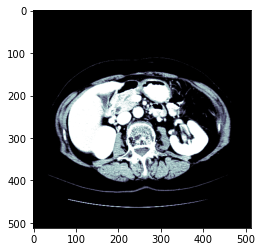

In [10]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [11]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

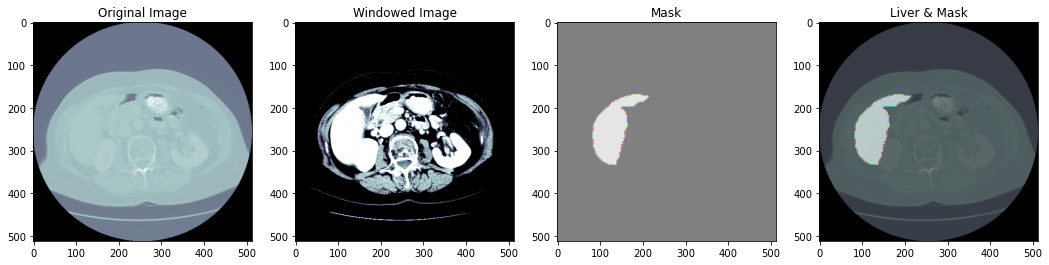

In [12]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [13]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


### Data Pre-processing

<AxesSubplot:>

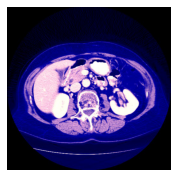

In [14]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [15]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("C:/Data/Vidhi/College/Queens/Term1/AI/input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output


  0%|          | 0/44 [00:00<?, ?it/s]

### Model Training

In [16]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')


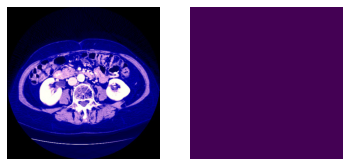

In [17]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [18]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)


[[     0 262144]]


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\vidhi\.conda\envs\ai\lib\site-packages\torch\_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


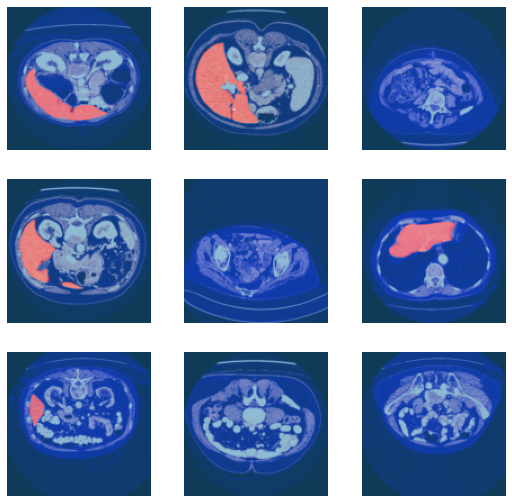

In [19]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

### Cyclical Learning

In [20]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [21]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

SuggestedLRs(valley=0.00015848931798245758)

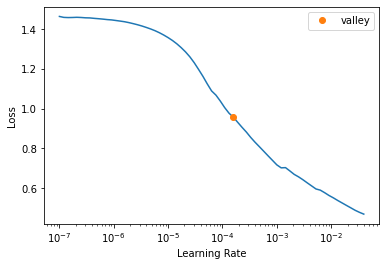

In [22]:
learn.lr_find()

In [23]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.011892,0.011190,nan,0.996049,04:43


Better model found at epoch 0 with valid_loss value: 0.01119047962129116.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.005910,0.007318,nan,0.997471,04:33
1,0.005580,0.005088,nan,0.998104,04:21
2,0.003748,0.004014,nan,0.998445,04:22
3,0.002958,0.003557,nan,0.998609,04:20
4,0.002586,0.003433,nan,0.998658,04:19


Better model found at epoch 0 with valid_loss value: 0.00731811486184597.
Better model found at epoch 1 with valid_loss value: 0.005088335368782282.
Better model found at epoch 2 with valid_loss value: 0.004013827536255121.
Better model found at epoch 3 with valid_loss value: 0.0035574769135564566.
Better model found at epoch 4 with valid_loss value: 0.003433494595810771.


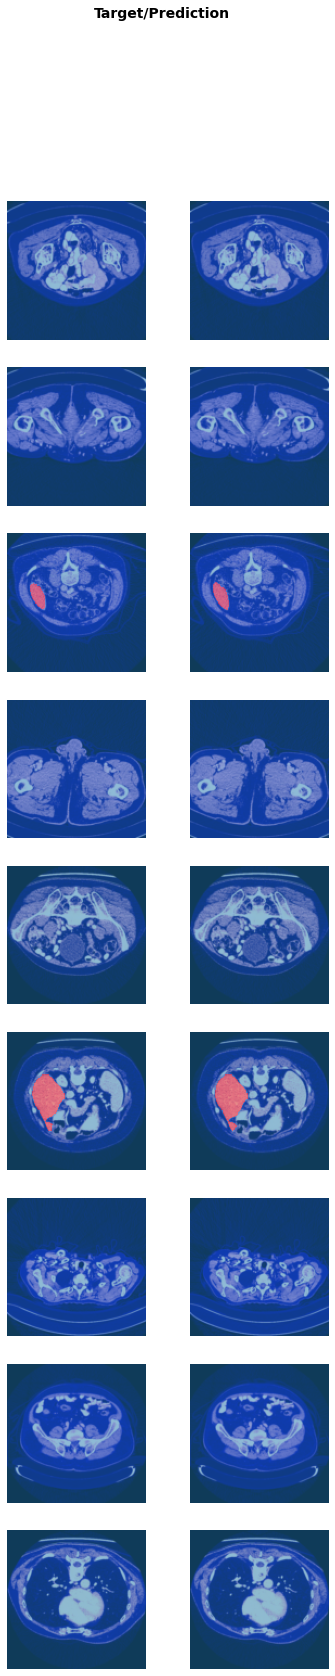

In [24]:
learn.show_results()

In [25]:
# Save the model
learn.export(path/f'Liver_segmentation')

In [26]:
# import gc
# del learn
# gc.collect()
# torch.cuda.empty_cache()

### Model Testing

In [27]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

In [28]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

(512, 512, 908)


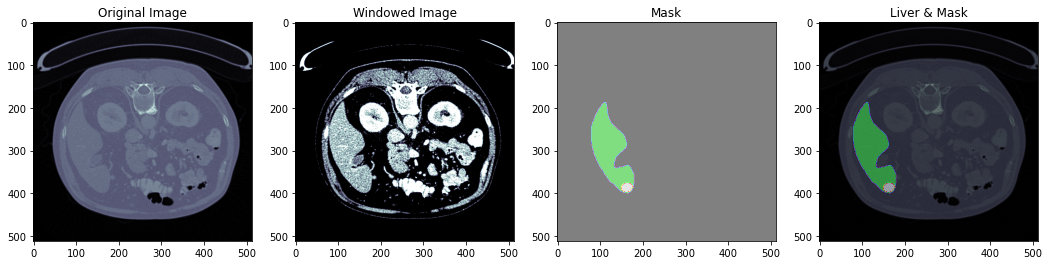

In [29]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [30]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

Number of test slices:  908


<AxesSubplot:>

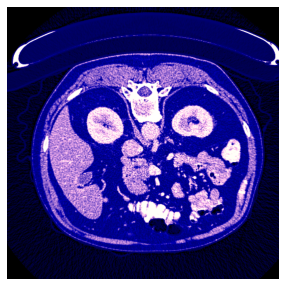

In [31]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

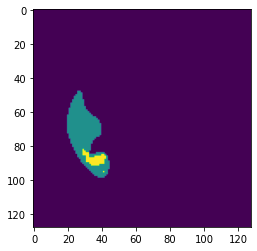

In [32]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])

In [33]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a)

(0, 2)

### Various Metrics calculation

In [34]:
# t = dls.valid_ds
# # dir(learn)
# # outputs = learn.pred_batch(ds_type=DatasetType.Valid)
# # outputs.shape
# t = learn.dls.valid
# outputs = learn.get_preds()
# outputs

In [35]:
# # outputs[0].shape # -- these are individual predictions for each class, so 3 channels -- 2018 images
# # outputs[1].shape # -- these are same predictions merged into 1 channel --  2018 images
# outputs[0][0][0]
# # I'll be back

In [36]:
# plt.imshow(outputs[1][66])

In [37]:
# to_np(ds[66][1])

In [38]:
# outputs[1][1]

In [39]:
# from sklearn.metrics import jaccard_score as jsc

# #average metrics
# accuracy_mean = []
# precision_mean = []
# recall_mean = []
# branching_f_mean = []
# miss_f_mean = []
# detection_p_mean = []
# iou_mean = []
# quality_p_mean = []

# for i in range(0,2):
#     # converting tensors to numpy arrays
#     ground_truth = to_np(outputs)
#     prediction = to_np(outputs[i][1].sigmoid()>0.95)
    
#     # converting ground truth to binary/boolean arrays for calculating metrics
#     gt = np.array(ground_truth[0], dtype=bool)
#     # prediction is already a binary array
    
#     if (not gt.sum()) or (not prediction.sum()):
#         continue
    
#     #getting TP, TN, FP, FN
#     TP = (gt & prediction).sum()
#     TN = np.invert(gt | prediction).sum()
#     FP = (prediction & np.invert(gt)).sum()
#     FN = (np.invert(prediction) & gt).sum()
    
#     # calculating metrics
#     iou = jsc(ground_truth[0].reshape(-1), prediction.reshape(-1))
#     branching_factor = FP/TP
#     miss_factor = FN/TP
#     detection_percentage = 100*(TP/(TP+FN))
#     quality_percentage = 100*(TP/(TP+FP+FN))
#     accuracy = (TP+TN)/(TP+TN+FP+FN)
#     precision = TP/(TP+FN)
#     recall = TP/(TP+FP)
    
#     accuracy_mean.append(accuracy)
#     precision_mean.append(precision)
#     recall_mean.append(recall)
#     branching_f_mean.append(branching_factor)
#     miss_f_mean.append(miss_factor)
#     detection_p_mean.append(detection_percentage)
#     quality_p_mean.append(quality_percentage)
#     iou_mean.append(iou)
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    
#     fig.suptitle("IoU: " + str(round(iou, 3)))
    
#     ax1.set_title('Input RGB Image')
#     data.valid_ds.x[i].show(ax=ax1)
    
#     ax2.set_title('Prediction')
#     data.valid_ds.x[i].show(ax=ax2)
#     ax2.imshow(prediction, alpha=0.5)
    
#     ax3.set_title('Ground Truth')
#     data.valid_ds.x[i].show(ax=ax3)
#     ax3.imshow(ground_truth[0], alpha=0.5)
#     plt.show()
    
#     print("Accuracy: ", round(accuracy,3))
#     print("Precision: ", round(precision,3))
#     print("Recall: ", round(recall,3))
#     print("Branching Factor: ", round(branching_factor,3))
#     print("Miss Factor: ", round(miss_factor,3))
#     print("Detection Percentage: ", round(detection_percentage,3))
#     print("Quality Percentage: ", round(quality_percentage,3))
#     print("************************".center(118))

# Data Preparation for Machine Learning Algorithms

In [40]:
X = sample_ct
y = sample_mask

X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
y = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
X.shape, y.shape

((262144, 75), (262144, 75))

# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

In [42]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [43]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training and Testing

In [44]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier = MultiOutputClassifier(rf, n_jobs = -1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                       n_estimators=10,
                                                       random_state=42),
                      n_jobs=-1)

In [45]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [46]:
print('Our prediction accuracy for Random Forest is: {score}%'.format(score=classifier.score(X_test, y_test) * 100))

Our prediction accuracy for Random Forest is: 96.60493238474889%


# Decision Tree

In [49]:
from sklearn import tree

### Model Training and Testing

In [50]:
dt = tree.DecisionTreeClassifier()
clf = MultiOutputClassifier(dt, n_jobs = -1)
clf = clf.fit(X_train, y_train)

In [51]:
# Predicting the Test set results
y_pred = clf.predict(X_test)

In [52]:
print('Our prediction accuracy for Decision Tree is: {score}%'.format(score=clf.score(X_test, y_test) * 100))

Our prediction accuracy for Decision Tree is: 92.263823456484%
